In [1]:
import scipy.io
import numpy as np
import pandas as pd
import os
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# Ignore all warnings
warnings.filterwarnings('ignore')

In [2]:
meta_path = "/kaggle/input/stanford-cars-dataset/car_devkit/devkit/cars_meta.mat"
train_annos_path = "/kaggle/input/stanford-cars-dataset/car_devkit/devkit/cars_train_annos.mat"

meta = scipy.io.loadmat(meta_path)
raw_classes = meta['class_names'].flatten()
class_names = [i.item() for i in raw_classes]

train_annos = scipy.io.loadmat(train_annos_path)
raw_annos = train_annos['annotations'][0]

data = []
for sample in raw_annos:
    fname = sample['fname'].item()
    class_id = sample['class'].item()
    class_name = class_names[class_id - 1]
    x1 = sample['bbox_x1'].item()
    y1 = sample['bbox_y1'].item()
    x2 = sample['bbox_x2'].item()
    y2 = sample['bbox_y2'].item()
    data.append([fname, class_id, class_name, x1, y1, x2, y2])

df_train = pd.DataFrame(data, columns=['filename', 'class_id', 'class_name', 'x1', 'y1', 'x2', 'y2'])
print(f"Total Images: {len(df_train)}")
print(f"Total Classes: {len(class_names)}")

Total Images: 8144
Total Classes: 196


In [3]:
class StanfordCarsDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['filename'])
        image = Image.open(img_path).convert('RGB')
        
        image = image.crop((row['x1'], row['y1'], row['x2'], row['y2']))
        
        label = int(row['class_id']) - 1
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [4]:
# I changed the image size to 224x224 because thats the default
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(10), # removed the flip and added rotation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
images_root = '/kaggle/input/stanford-cars-dataset/cars_train/cars_train'

# Split: 70% Train, 15% Val, 15% Test
train_df, test_df1 = train_test_split(
    df_train, 
    test_size=0.3, 
    random_state=42, 
    stratify=df_train['class_id']
)

test_df, val_df = train_test_split(
    test_df1, 
    test_size=0.5, 
    random_state=42, 
    stratify=test_df1['class_id']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

# Create datasets
train_ds = StanfordCarsDataset(train_df, images_root, transform=train_transforms)
val_ds = StanfordCarsDataset(val_df, images_root, transform=test_transforms)  # Fix #2
test_ds = StanfordCarsDataset(test_df, images_root, transform=test_transforms)

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

Training samples: 5700
Validation samples: 1222
Testing samples: 1222


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)

num_labels = len(class_names)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_labels)


model = model.to(device)
print(f"Model ready: Inception V1 for {num_labels} classes")

Using device: cuda


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 168MB/s]


Model ready: Inception V1 for 196 classes


In [7]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path='best_checkpoint.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss improved. Saving model...')

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True


optimizer_phase1 = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler_phase1 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_phase1, mode='min', factor=0.5, patience=2, verbose=True
)
early_stopper_phase1 = EarlyStopping(patience=5, path='phase1_best.pth')
criterion = nn.CrossEntropyLoss()

num_epochs_phase1 = 10

for epoch in range(num_epochs_phase1):
    print(f"\n=== Phase 1 - Epoch {epoch+1}/{num_epochs_phase1} ===")
    
    model.train()
    train_loss = 0
    train_correct = 0
    
    loop = tqdm(train_loader, desc="Training")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer_phase1.zero_grad()
        
        # Inception has auxiliary outputs during training
        if model.training and hasattr(model, 'aux_logits') and model.aux_logits:
            outputs, aux2, aux1 = model(images)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux2, labels)
            loss3 = criterion(aux1, labels)
            loss = loss1 + 0.3 * loss2 + 0.3 * loss3
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer_phase1.step()
        
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        
        loop.set_postfix(loss=loss.item())
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    
    model.eval()
    val_loss = 0
    val_correct = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    scheduler_phase1.step(avg_val_loss)
    early_stopper_phase1(avg_val_loss, model)
    
    if early_stopper_phase1.early_stop:
        print("Phase 1 early stopping triggered!")
        break

model.load_state_dict(torch.load('phase1_best.pth'))
print("Phase 1 complete. Loaded best weights.")

In [ ]:
print("\n" + "="*70)
print("PHASE 2: Fine-tuning all layers")
print("="*70)

for param in model.parameters():
    param.requires_grad = True

optimizer_phase2 = optim.Adam(model.parameters(), lr=1e-3)
scheduler_phase2 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_phase2, mode='min', factor=0.1, patience=2, verbose=True
)
early_stopper_phase2 = EarlyStopping(patience=5, path='phase2_best.pth')

num_epochs_phase2 = 15

for epoch in range(num_epochs_phase2):
    print(f"\n=== Phase 0 - Epoch {epoch+1}/{num_epochs_phase2} ===")
    
    model.train()
    train_loss = 0
    train_correct = 0
    
    loop = tqdm(train_loader, desc="Training")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer_phase2.zero_grad()
        
        if model.training and hasattr(model, 'aux_logits') and model.aux_logits:
            outputs, aux2, aux1 = model(images)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux2, labels)
            loss3 = criterion(aux1, labels)
            loss = loss1 + 0.3 * loss2 + 0.3 * loss3
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer_phase2.step()
        
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        
        loop.set_postfix(loss=loss.item())
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    
    model.eval()
    val_loss = 0
    val_correct = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    scheduler_phase2.step(avg_val_loss)
    early_stopper_phase2(avg_val_loss, model)
    
    if early_stopper_phase2.early_stop:
        print("Phase 2 early stopping triggered!")
        break

model.load_state_dict(torch.load('phase2_best.pth'))
print("Phase 2 complete. Loaded best weights.")

In [9]:
print("\n" + "="*70)
print("NO PHASE: Fine-tuning all layers at once")
print("="*70)

for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

optimizer_phase2 = optim.Adam(model.parameters(), lr=1e-4)
scheduler_phase2 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_phase2, mode='min', factor=0.1, patience=2, verbose=True
)
early_stopper_phase2 = EarlyStopping(patience=5, path='phase2_best.pth')

num_epochs_phase2 = 15

for epoch in range(num_epochs_phase2):
    print(f"\n=== Phase 2 - Epoch {epoch+1}/{num_epochs_phase2} ===")
    
    model.train()
    train_loss = 0
    train_correct = 0
    
    loop = tqdm(train_loader, desc="Training")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer_phase2.zero_grad()
        
        if model.training and hasattr(model, 'aux_logits') and model.aux_logits:
            outputs, aux2, aux1 = model(images)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux2, labels)
            loss3 = criterion(aux1, labels)
            loss = loss1 + 0.3 * loss2 + 0.3 * loss3
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer_phase2.step()
        
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        
        loop.set_postfix(loss=loss.item())
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    
    model.eval()
    val_loss = 0
    val_correct = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    scheduler_phase2.step(avg_val_loss)
    early_stopper_phase2(avg_val_loss, model)
    
    if early_stopper_phase2.early_stop:
        print("Phase 2 early stopping triggered!")
        break

model.load_state_dict(torch.load('phase2_best.pth'))
print("Phase 2 complete. Loaded best weights.")


NO PHASE: Fine-tuning all layers at once

=== Phase 2 - Epoch 1/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 5.1622 | Train Acc: 0.0247
Val Loss:   4.8161 | Val Acc:   0.0982
Validation loss improved. Saving model...

=== Phase 2 - Epoch 2/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 4.4967 | Train Acc: 0.1486
Val Loss:   4.1131 | Val Acc:   0.2619
Validation loss improved. Saving model...

=== Phase 2 - Epoch 3/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 3.7501 | Train Acc: 0.3233
Val Loss:   3.3697 | Val Acc:   0.4149
Validation loss improved. Saving model...

=== Phase 2 - Epoch 4/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 3.0430 | Train Acc: 0.4725
Val Loss:   2.7278 | Val Acc:   0.5229
Validation loss improved. Saving model...

=== Phase 2 - Epoch 5/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 2.4197 | Train Acc: 0.6160
Val Loss:   2.2258 | Val Acc:   0.6031
Validation loss improved. Saving model...

=== Phase 2 - Epoch 6/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.8743 | Train Acc: 0.7389
Val Loss:   1.7779 | Val Acc:   0.6841
Validation loss improved. Saving model...

=== Phase 2 - Epoch 7/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.4215 | Train Acc: 0.8100
Val Loss:   1.4943 | Val Acc:   0.7439
Validation loss improved. Saving model...

=== Phase 2 - Epoch 8/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 1.0575 | Train Acc: 0.8611
Val Loss:   1.2003 | Val Acc:   0.7840
Validation loss improved. Saving model...

=== Phase 2 - Epoch 9/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.7695 | Train Acc: 0.9079
Val Loss:   1.0463 | Val Acc:   0.7864
Validation loss improved. Saving model...

=== Phase 2 - Epoch 10/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.5674 | Train Acc: 0.9360
Val Loss:   0.9070 | Val Acc:   0.8151
Validation loss improved. Saving model...

=== Phase 2 - Epoch 11/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.4106 | Train Acc: 0.9553
Val Loss:   0.8176 | Val Acc:   0.8249
Validation loss improved. Saving model...

=== Phase 2 - Epoch 12/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.3002 | Train Acc: 0.9663
Val Loss:   0.7480 | Val Acc:   0.8322
Validation loss improved. Saving model...

=== Phase 2 - Epoch 13/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.2222 | Train Acc: 0.9758
Val Loss:   0.7124 | Val Acc:   0.8347
Validation loss improved. Saving model...

=== Phase 2 - Epoch 14/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1648 | Train Acc: 0.9837
Val Loss:   0.6875 | Val Acc:   0.8290
Validation loss improved. Saving model...

=== Phase 2 - Epoch 15/15 ===


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1182 | Train Acc: 0.9889
Val Loss:   0.6585 | Val Acc:   0.8421
Validation loss improved. Saving model...
Phase 2 complete. Loaded best weights.


In [10]:
def evaluate_model(model, loader, device):
    model.eval()
    
    correct_1 = 0
    correct_5 = 0
    total = 0
    
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            # --- Top-1 Accuracy ---
            _, pred_1 = torch.max(outputs, 1)
            correct_1 += (pred_1 == labels).sum().item()
            
            # --- Top-5 Accuracy ---
            _, pred_5 = outputs.topk(5, 1, largest=True, sorted=True)
            
            correct_5 += (pred_5 == labels.view(-1, 1)).sum().item()
            
            total += labels.size(0)
            
            all_preds.extend(pred_1.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    top1_acc = correct_1 / total
    top5_acc = correct_5 / total
    
    return top1_acc, top5_acc, all_labels, all_preds


device = torch.device("cuda")
model.load_state_dict(torch.load('phase2_best.pth'))
acc_1, acc_5, y_true, y_pred = evaluate_model(model, test_loader, device)

print("-" * 30)
print(f"Top-1 Accuracy: {acc_1*100:.2f}%")
print(f"Top-5 Accuracy: {acc_5*100:.2f}%")
print("-" * 30)

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

------------------------------
Top-1 Accuracy: 83.80%
Top-5 Accuracy: 96.32%
------------------------------


In [12]:
from sklearn.metrics import classification_report

print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


DETAILED CLASSIFICATION REPORT
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000     0.7778    1.0000    0.8750         7
                                   Acura RL Sedan 2012     1.0000    0.8000    0.8889         5
                                   Acura TL Sedan 2012     0.8571    1.0000    0.9231         6
                                  Acura TL Type-S 2008     1.0000    0.6667    0.8000         6
                                  Acura TSX Sedan 2012     1.0000    1.0000    1.0000         6
                             Acura Integra Type R 2001     0.6667    0.6667    0.6667         6
                              Acura ZDX Hatchback 2012     0.8571    1.0000    0.9231         6
              Aston Martin V8 Vantage Convertible 2012     0.5000    0.5714    0.5333         7
                    Aston Martin V8 Vantage Coupe 2012     0.7500    0.5000    0.6000         6
       


SAMPLE MISCLASSIFICATIONS


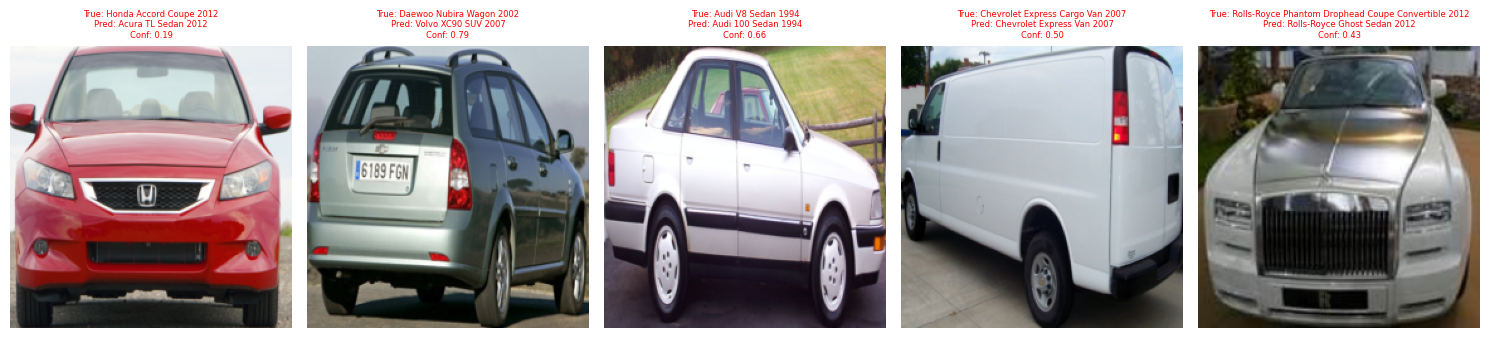

In [13]:
import matplotlib.pyplot as plt

def visualize_failures(model, loader, device, num_images=5):
    model.eval()
    images_shown = 0
    
    plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs, preds = torch.max(torch.softmax(outputs, dim=1), 1)
            
            for i in range(len(images)):
                if preds[i] != labels[i]:
                    if images_shown >= num_images:
                        plt.tight_layout()
                        plt.show()
                        return
                    
                    # Undo normalization
                    img = images[i].cpu().permute(1, 2, 0).numpy()
                    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
                    img = np.clip(img, 0, 1)
                    
                    true_name = class_names[labels[i].item()]
                    pred_name = class_names[preds[i].item()]
                    confidence = probs[i].item()
                    
                    ax = plt.subplot(1, num_images, images_shown + 1)
                    plt.imshow(img)
                    plt.title(f"True: {true_name}\nPred: {pred_name}\nConf: {confidence:.2f}", 
                             fontsize=6, color='red')
                    plt.axis('off')
                    
                    images_shown += 1
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("SAMPLE MISCLASSIFICATIONS")
print("="*70)
visualize_failures(model, test_loader, device, num_images=5)

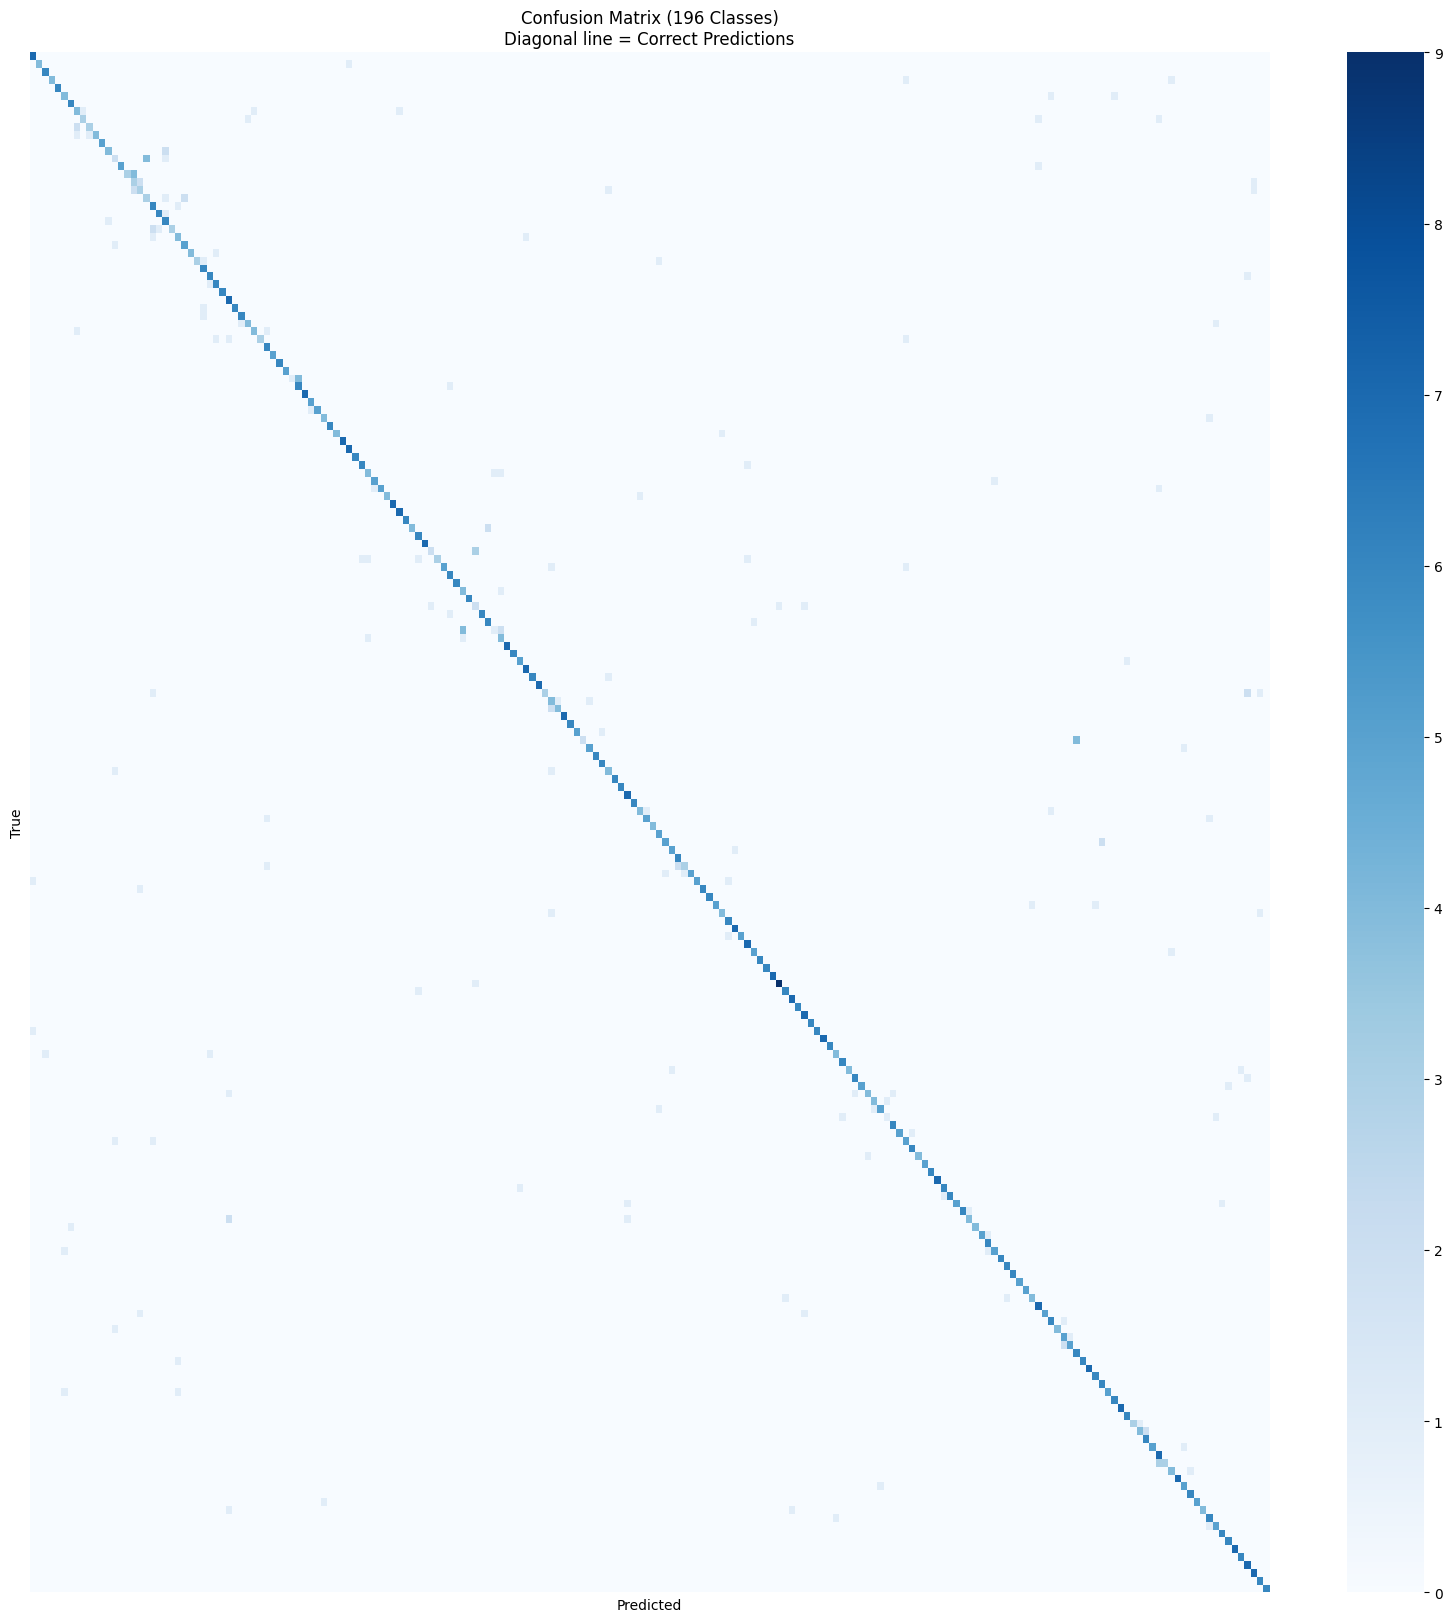

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=False, yticklabels=False) # Labels hidden for clarity

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (196 Classes)\nDiagonal line = Correct Predictions')
plt.show()

Getting Probabilities:   0%|          | 0/39 [00:00<?, ?it/s]

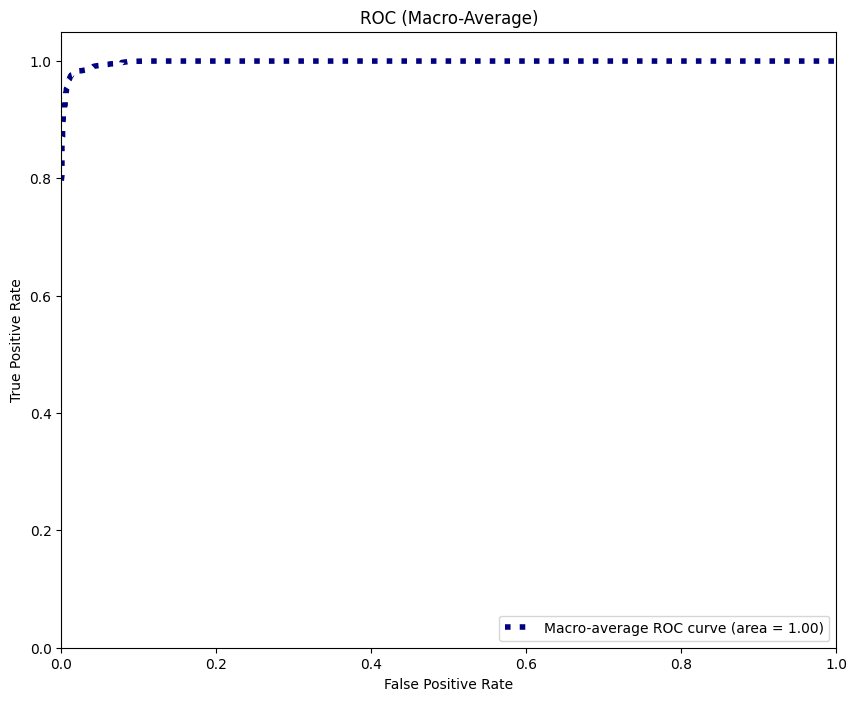

In [18]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def get_all_probs(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Getting Probabilities"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1) # Convert logits to probabilities
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())
            
    return np.concatenate(all_probs), np.concatenate(all_labels)

y_probs, y_test_np = get_all_probs(model, test_loader, device)

n_classes = len(class_names)
y_test_bin = label_binarize(y_test_np, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5. Plotting
plt.figure(figsize=(10, 8))
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Macro-Average)')
plt.legend(loc="lower right")
plt.show()


TOP 10 EASIEST CARS (Highest AUC)
1.0000 | AM General Hummer SUV 2000
1.0000 | Acura RL Sedan 2012
1.0000 | Acura TL Sedan 2012
1.0000 | Acura TSX Sedan 2012
1.0000 | Acura ZDX Hatchback 2012
1.0000 | Audi RS 4 Convertible 2008
1.0000 | Audi R8 Coupe 2012
1.0000 | BMW 6 Series Convertible 2007
1.0000 | BMW X5 SUV 2007
1.0000 | BMW X6 SUV 2012

BOTTOM 10 HARDEST CARS (Lowest AUC)
0.9911 | Acura TL Type-S 2008
0.9910 | Dodge Caliber Wagon 2012
0.9891 | Daewoo Nubira Wagon 2002
0.9888 | BMW M5 Sedan 2010
0.9870 | Audi TT RS Coupe 2012
0.9862 | Toyota Sequoia SUV 2012
0.9846 | BMW 3 Series Sedan 2012
0.9842 | Aston Martin V8 Vantage Coupe 2012
0.9826 | Ford Edge SUV 2012
0.9822 | Hyundai Elantra Sedan 2007


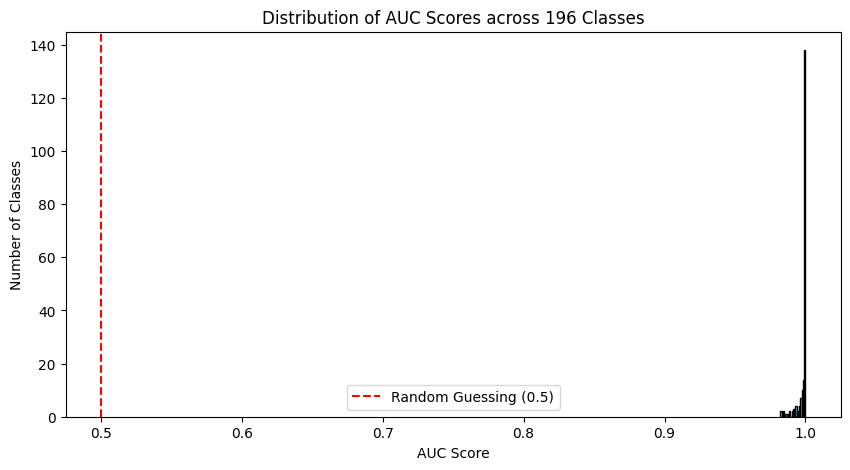

In [17]:
auc_scores = []
for i in range(len(class_names)):
    auc_scores.append((class_names[i], roc_auc[i]))

auc_scores.sort(key=lambda x: x[1], reverse=True)

print("\n" + "="*40)
print("Highest AUC Scores)")
print("="*40)
for name, score in auc_scores[:10]:
    print(f"{score:.4f} | {name}")

print("\n" + "="*40)
print("Lowest AUC Scores")
print("="*40)
for name, score in auc_scores[-10:]:
    print(f"{score:.4f} | {name}")

plt.figure(figsize=(10, 5))
plt.hist([score for name, score in auc_scores], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of AUC Scores across 196 Classes')
plt.xlabel('AUC Score')
plt.ylabel('Number of Classes')
plt.axvline(x=0.5, color='red', linestyle='--', label='Random Guessing (0.5)')
plt.legend()
plt.show()